In [124]:
import pandas as pd
import pyproj
import geopandas as gpd
import numpy as np
from shapely.geometry import Point, Polygon

In [125]:
# in 07, there's an error on how to define the polygon => here we define a square

In [126]:
MQ_CARREAU_200_2017 = 'data/Filosofi2017_carreaux_200m_mart.csv'
df = pd.read_csv(MQ_CARREAU_200_2017)
use_200 = False
if use_200:
    df['n'] = df['Idcar_200m'].str[15:22].astype(int)
    df['e'] = df['Idcar_200m'].str[23:].astype(int)
    def poly(x):
        arr = [[x[1] + dy, x[0] + dx] for dx, dy in [(0,0), (0, 199), (199, 199), (199, 0)]]
        return arr
    df['geometry'] = df[['n', 'e']].apply(lambda x: Polygon(poly(x)), axis=1)
else:
    # here I could use the 1km but it's remix, so get the Inv sum
    df['n'] = df['Idcar_1km'].str[16:23].astype(int)
    df['e'] = df['Idcar_1km'].str[24:].astype(int)
    df = df.groupby(by=['n', 'e']).agg(Ind=('Ind', 'sum')).reset_index()
    def poly(x):
        arr = [[x[1] + dy, x[0] + dx] for dx, dy in [(0,0), (0, 999), (999, 999), (999, 0)]]
        return arr
    df['geometry'] = df[['n', 'e']].apply(lambda x: Polygon(poly(x)), axis=1)
df = df[['geometry', 'Ind']]

In [127]:
crs_5490 = pyproj.crs.CRS.from_user_input("""
PROJCRS["RGAF09 / UTM zone 20N",
    BASEGEOGCRS["RGAF09",
        DATUM["Reseau Geodesique des Antilles Francaises 2009",
            ELLIPSOID["GRS 1980",6378137,298.257222101,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",5489]],
    CONVERSION["UTM zone 20N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",-63,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",500000,
            LENGTHUNIT["metre",1],
            ID["EPSG",8806]],
        PARAMETER["False northing",0,
            LENGTHUNIT["metre",1],
            ID["EPSG",8807]]],
    CS[Cartesian,2],
        AXIS["(E)",east,
            ORDER[1],
            LENGTHUNIT["metre",1]],
        AXIS["(N)",north,
            ORDER[2],
            LENGTHUNIT["metre",1]],
    USAGE[
        SCOPE["Engineering survey, topographic mapping."],
        AREA["French Antilles onshore and offshore west of 60°W - Guadeloupe (including Grande Terre, Basse Terre, Marie Galante, Les Saintes, Iles de la Petite Terre, La Desirade); Martinique; St Barthélemy; northern St Martin."],
        BBOX[14.08,-63.66,18.31,-60]],
    ID["EPSG",5490]]
""")

<AxesSubplot:>

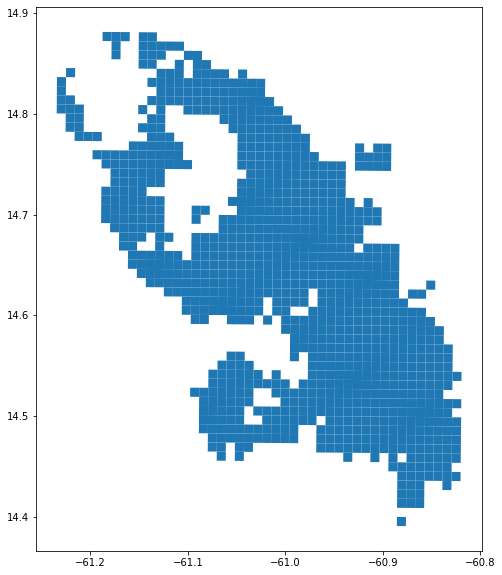

In [128]:
gdf = gpd.GeoDataFrame(df)
gdf = gdf.set_crs(crs_5490, allow_override=True)
#, crs=crs_5490)#'espg:5490')
#print(gdf.crs, gdf['geometry'].crs)
gdf = gdf.to_crs(epsg=4326)
gdf.plot(figsize=(10,10))

In [129]:
accidents = pd.read_csv('data/accidents.csv')
accidents['geometry'] = accidents.apply(lambda x: Point(x['lng'], x['lat']), axis=1)
gdf_accidents = gpd.GeoDataFrame(accidents).set_crs(4326, allow_override=True)

/home/glefait/.virtualenvs/notebooks/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


<AxesSubplot:>

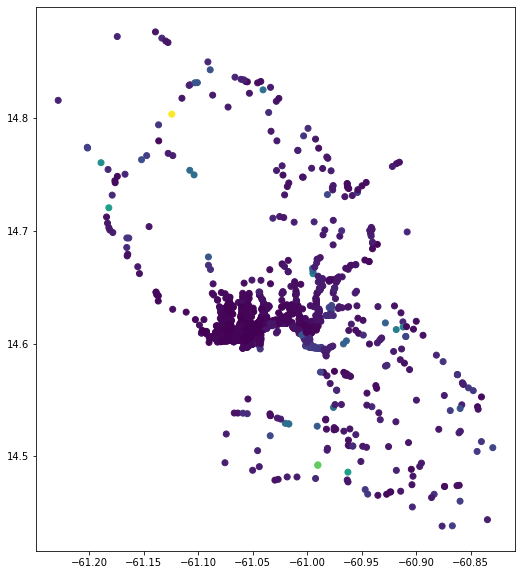

In [130]:
both = gpd.sjoin(gdf, gdf_accidents, how="right", predicate='intersects').dropna()
both['loginvdensity'] = 1 / np.log(both['Ind'] + 1)
both['invdensity'] = 1 / (both['Ind'] + 1)
both.plot(figsize=(10,10), column='loginvdensity')

In [131]:
both = both[['lng', 'lat', 'loginvdensity', 'invdensity']]
both.to_csv('data/accidents-density.csv', index=False)